In [1]:
import jax.numpy as jnp
import struct


def read_label(file):
    with open(file, "rb") as f:
        struct.unpack(">II", f.read(8))
        return jnp.frombuffer(f.read(), dtype=jnp.uint8)

def read_image(file):
    with open(file, "rb") as f:
        struct.unpack(">IIII", f.read(16))
        return jnp.frombuffer(f.read(), dtype=jnp.uint8)

X_train = read_image("./train-images.idx3-ubyte")
Y_train = read_label("./train-labels.idx1-ubyte")
X_test = read_image("./t10k-images.idx3-ubyte")
Y_test = read_label("./t10k-labels.idx1-ubyte")

X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

In [2]:
import jax
import matplotlib.pyplot as plt

key = jax.random.key(0)
key, W1_key, b1_key, W2_key, b2_key = jax.random.split(key, 5)

params = {
    "W1": jax.random.normal(W1_key, (28 * 28, 128)) * 0.1,
    "b1": jax.random.normal(b1_key, (128,)) * 0.1,
    "W2": jax.random.normal(W2_key, (128, 10)) * 0.1,
    "b2": jax.random.normal(b2_key, (10,)) * 0.1
}

def eval(params, x, y):
    W1, W2, b1, b2 = params["W1"], params["W2"], params["b1"], params["b2"]
    logits = jax.nn.relu(jnp.dot(x, W1) + b1)
    logits = jnp.dot(logits, W2) + b2

    log_probs = jax.nn.log_softmax(logits)
    loss_val = -jnp.mean(jax.nn.one_hot(y, 10) * log_probs)

    preds = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(preds == y)
    return loss_val, accuracy


grad_fn = jax.grad(eval, has_aux=True)

@jax.jit
def step(params, x, y, lr=0.01):
    loss_val, _ = eval(params, x, y)
    grads, acc = grad_fn(params, x, y)

    new_params = {
        "W1": params["W1"] - lr * grads["W1"],
        "b1": params["b1"] - lr * grads["b1"],
        "W2": params["W2"] - lr * grads["W2"],
        "b2": params["b2"] - lr * grads["b2"]
    }

    return new_params, loss_val, acc

bs = 32
nepochs = 10000
losses = []
accs = []
for i in range(nepochs+1):
    key, subkey = jax.random.split(key)
    samp = jax.random.randint(subkey, (bs,), 0, X_train.shape[0])
    X, Y = X_train[samp], Y_train[samp]
    params, curr_loss, acc = step(params, X, Y)
    losses.append(curr_loss)
    accs.append(acc)
    if i % 500 == 0: print(f"Epoch {i+1}/{nepochs}, Loss: {curr_loss}, Accuracy: {acc*100:.2f}%")


Epoch 1/10000, Loss: 19.733854293823242, Accuracy: 12.50%
Epoch 501/10000, Loss: 0.16958101093769073, Accuracy: 75.00%
Epoch 1001/10000, Loss: 0.22560326755046844, Accuracy: 71.88%
Epoch 1501/10000, Loss: 0.062071651220321655, Accuracy: 87.50%
Epoch 2001/10000, Loss: 0.15275520086288452, Accuracy: 75.00%
Epoch 2501/10000, Loss: 0.08044341951608658, Accuracy: 81.25%
Epoch 3001/10000, Loss: 0.09110000729560852, Accuracy: 78.12%
Epoch 3501/10000, Loss: 0.054757531732320786, Accuracy: 81.25%
Epoch 4001/10000, Loss: 0.08000491559505463, Accuracy: 84.38%
Epoch 4501/10000, Loss: 0.053907234221696854, Accuracy: 87.50%
Epoch 5001/10000, Loss: 0.04168374463915825, Accuracy: 87.50%
Epoch 5501/10000, Loss: 0.04633262753486633, Accuracy: 90.62%
Epoch 6001/10000, Loss: 0.027250289916992188, Accuracy: 90.62%
Epoch 6501/10000, Loss: 0.05816629156470299, Accuracy: 93.75%
Epoch 7001/10000, Loss: 0.059656381607055664, Accuracy: 90.62%
Epoch 7501/10000, Loss: 0.12991999089717865, Accuracy: 71.88%
Epoch 80

In [3]:
evals = eval(params, X_test, Y_test)
print(evals[1])

0.89449996


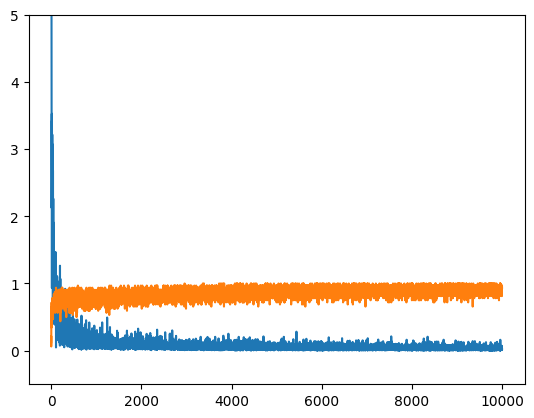

In [4]:
plt.ylim(-0.5, 5)
plt.plot(losses)
plt.plot(accs)